<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot, os, dill
import minepy as mp
from iminuit import Minuit
from scipy.optimize import curve_fit
from ExternalFunctions import Chi2Regression
from scipy.stats import norm, chi2

In [2]:
# Load Data
# data_path = "../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
data_path = "../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

load_variables = "v0_rxy v0_chi2 cosTheta v0_ks_mass v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y trueKs".split(" ")

df = data_tree.pandas.df(load_variables, entrystart = 5 *  10 **6, entrystop = 5 * 10 ** 6 +  10 * 10**5)


In [3]:
# define probability variable
model_path = "models/data_trained_xg.dat"

func_seri = dill.load(open(model_path, 'rb'))
prob_func = dill.loads(func_seri)

In [4]:
df = prob_func(df)

<string>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
from scipy.special import logit, expit

In [6]:
logit_probs = df.prob.apply(logit)
# plt.hist(df.prob.apply(logit), bins = 50);

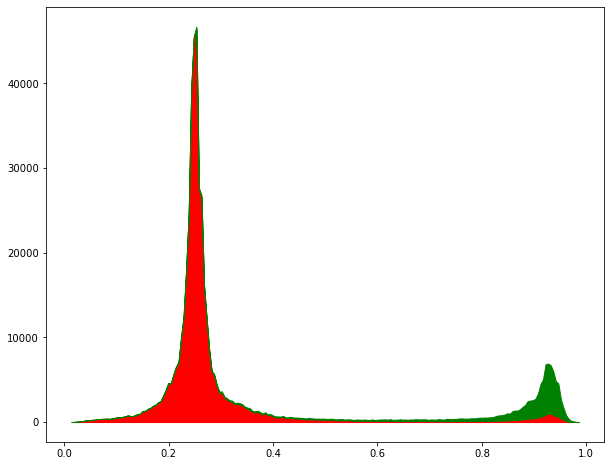

In [7]:
rang = (400, 600)
Nbins = 200

probs_true, edges = np.histogram(df.prob[df.trueKs == 1], bins = Nbins)
probs_false, edges = np.histogram(df.prob[df.trueKs == 0], bins = Nbins)

xs = (edges[1:] + edges[:-1])/2

fig, ax = plt.subplots(figsize = (10, 8))
ax.fill_between(xs, probs_false, color = 'r')
ax.fill_between(xs, probs_true + probs_false, probs_false, color = "g")

In [8]:
def fit_data(mass, logit_probs, cut = - 5.00, bins = 100, ranges = None, guesses_bkgr = [0, 0, -10, 2000], \
             guesses_sig = [498, 6, 80000, 0.95, 2.5], lower_amount = 100, ax = None):
    # Cut the data
    mass = mass[logit_probs > cut].copy()
    
    if len(mass) < lower_amount:
        return None
    
    vals, bins = np.histogram(mass, bins = bins, range = ranges)
    xs = (bins[1:] + bins[:-1])/2
    binwidth = xs[1] - xs[0]
    
    mask = vals > 0
    vals = vals[mask]
    xs = xs[mask]
    errs = np.sqrt(vals)
    
    # Fit the background using third degree polynomium
    def background_fit(x, a, b, c, d):
        return a * (x- 498) ** 3 + b * (x-498) ** 2 + c * (x-498) + d
    
    vals_b, cov_b = curve_fit(background_fit, xs, vals, p0 = guesses_bkgr)
    b1, b2, b3, b4 = vals_b
    
    bkgr_chi2 = Chi2Regression(background_fit, xs, vals, errs)
    bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
    
    bkgr_min.migrad()
    
    
    def add_signal(x, mean, sig, size, ratio, sig_ratio):
        return size * binwidth *  (ratio * norm.pdf(x, mean, sig) + \
                                   (1 - ratio) * norm.pdf(x, mean, sig_ratio * sig))
    
    def full_fit(x, mean, sig, size, ratio, sig_ratio, a, b, c, d):
        return background_fit(x, a, b, c, d) + add_signal(x, mean, sig, size, ratio, sig_ratio)
    
    
    b1, b2, b3, b4 = bkgr_min.args
    s1, s2, s3, s4, s5 = guesses_sig    
    
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = s1, sig = s2, size = s3, ratio = s4, sig_ratio = s5, limit_sig_ratio = (1.5, 3), \
                       limit_ratio = (0.75, 1.0))
    
    full_min.migrad()
    
    chi = full_min.fval 
    pval = chi2.sf(chi, np.sum(mask) - len(full_min.args))
    
    if ax:
        ax.plot(xs, vals, 'r.')
        ax.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, linestyle = 'None')
        ax.plot(xs, full_fit(xs, *full_min.args))
        
    print(f"Completed fit with Chi2: {chi:.2f}, p-val: {pval:.2f} and the total amount of signal " + \
          f"{full_min.values['size']:.0f} +/- {full_min.errors['size']:.0f}, background: {len(mass) - int(full_min.values['size'])}")
    return full_min, len(mass)

Completed fit with Chi2: 285.83, p-val: 0.00 and the total amount of signal 85762 +/- 954, background: 437020
Completed fit with Chi2: 285.82, p-val: 0.00 and the total amount of signal 85765 +/- 683, background: 437002
Completed fit with Chi2: 286.16, p-val: 0.00 and the total amount of signal 85791 +/- 630, background: 436620
Completed fit with Chi2: 284.89, p-val: 0.00 and the total amount of signal 85835 +/- 935, background: 435594
Completed fit with Chi2: 284.16, p-val: 0.00 and the total amount of signal 85878 +/- 550, background: 434012
Completed fit with Chi2: 287.09, p-val: 0.00 and the total amount of signal 86036 +/- 947, background: 432024
Completed fit with Chi2: 290.11, p-val: 0.00 and the total amount of signal 86082 +/- 596, background: 429390
Completed fit with Chi2: 287.19, p-val: 0.00 and the total amount of signal 86207 +/- 1953, background: 425898
Completed fit with Chi2: 289.70, p-val: 0.00 and the total amount of signal 86038 +/- 526, background: 420649
Completed

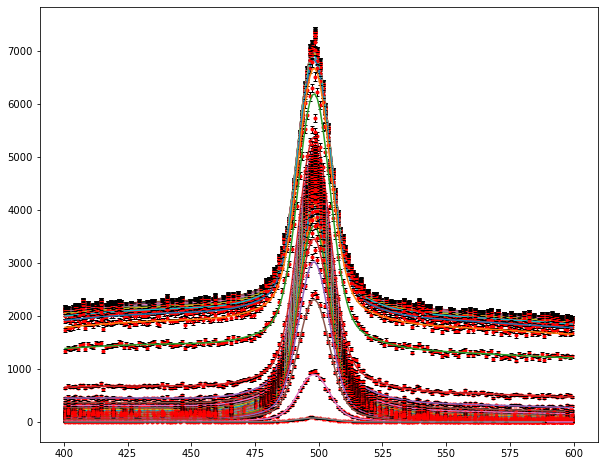

In [9]:
cuts = np.linspace(0, 1, 50)
sizes = []
backgrounds = []
plt.ion()

fig, ax = plt.subplots(figsize = (10, 8))

for val in cuts:
    try:
        full_min, back = fit_data(df.v0_ks_mass, df.prob, cut = val, ranges = (400, 600), ax = ax, bins = 200)
        sizes.append(full_min.values['size'])
        backgrounds.append(back)
    except:
         pass

In [10]:
sizes = np.array(sizes)
background = np.array(backgrounds)

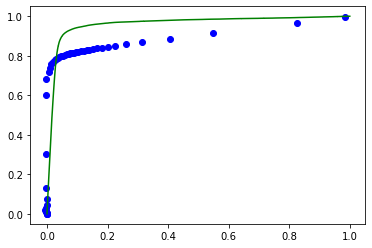

In [11]:
from sklearn.metrics import roc_curve

x, y, _ = roc_curve(df.trueKs, df.prob)

plt.plot(1 - (sizes / sizes[0]), 1 - (background / background[0]), 'b-')
plt.plot(x, y, 'g-')

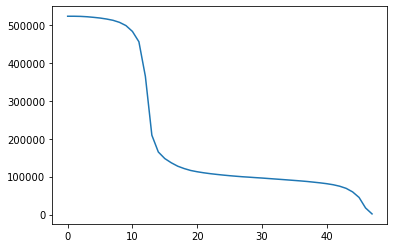

In [12]:
plt.plot(background)

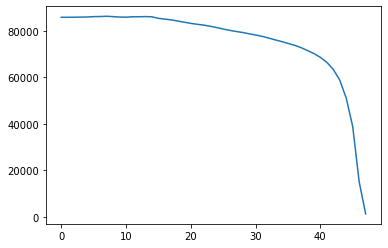

In [13]:
plt.plot(sizes)